In [222]:
import numpy as np
import sympy as sp
import scipy as sc
import matplotlib.pyplot as plt
import ipywidgets as ip
import scipy.optimize as spo
import timeit
import decimal
import scipy.linalg
import mpmath
from matplotlib.pyplot import figure
from sympy import exp, N, S
from sympy.matrices import Matrix
from sympy import *
from sympy.stats import *
from mpmath import *
from mpmath import mp, timing
from mpmath import iv
from flint import acb_mat, arb_mat , ctx , arb

In [265]:
def log_of_norm(v,E):
    N = len(v)
    A = np.zeros((N,2,2),dtype = np.float128)
    Nt = np.zeros((N,2,2),dtype = np.float128)
    for i in range(N):
        A[i][0][0] = E - v[i]
        A[i][0][1] = -1
        A[i][1][0] = 1
        A[i][1][1] = 0
    Nt[0] = [[1,0],[0,1]]
    for i in range(N-1):
        Nt[i+1] = np.dot(A[i],Nt[i])
    return np.log(np.linalg.norm(Nt[N-1]))

def avg_of_log_of_norm(E,M,N):
    rx = np.zeros(M,dtype = np.float128)
    for i in range(M):
        v1 = np.random.random(N)
        w = np.zeros(N)
        for j in range(N):
            if v1[j] <= 0.5:
                w[j] = v1[j]-1.5
            else:
                w[j] = v1[j]+0.5
        rx[i] = log_of_norm(w,E)
    return np.mean(rx)

def Periodic_Hamiltonian(v):
    N = len(v)
    M = mp.matrix(N)
    for i in range(N):
        M[i,i] = v[i]
    for i in range(N-1):
        M[i,i+1] = 1
        M[i+1,i] = 1
        
    M[0,N-1] = 1
    M[N-1,0] = 1
    return arb_mat(M)

def Antiperiodic_Hamiltonian(v):
    N = len(v)
    M = mp.matrix(N)
    for i in range(N):
        M[i,i] = v[i]
    for i in range(N-1):
        M[i,i+1] = 1
        M[i+1,i] = 1
        
    M[0,N-1] = -1
    M[N-1,0] = -1
    return arb_mat(M)

In [287]:
start = timeit.default_timer() 

Nrealisations = 4000;
Nperiod = 1500;

energies = np.linspace(-4, 4,150)
Lyapunovexponent = np.zeros(len(energies))

for i in range(len(Lyapunovexponent)):
    Lyapunovexponent[i] = (1/Nperiod)*avg_of_log_of_norm(energies[i],Nrealisations,Nperiod)
    
stop = timeit.default_timer()    
print('Time elapsed: ', stop - start)

Time elapsed:  6207.489603165974


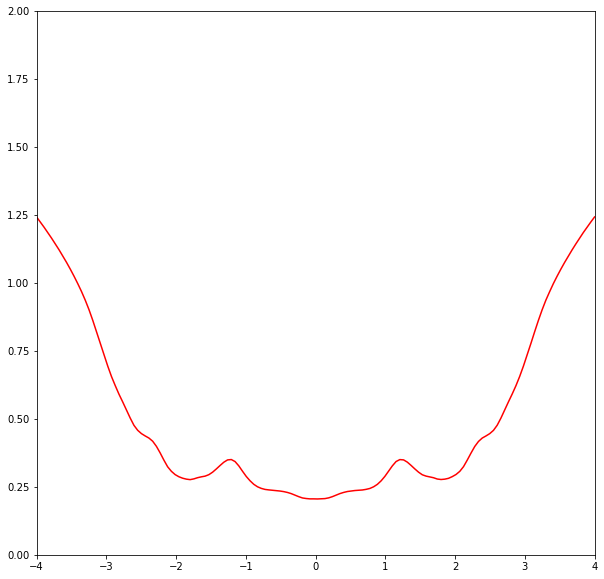

In [288]:
fig, ax = plt.subplots(figsize = (10,10))
ax.plot(energies,Lyapunovexponent,'r-',linewidth = 1.5)
ax.set(xlim=(-4, 4),ylim=(0, 2))
plt.savefig('IID_bandwidths.eps')

In [309]:
start = timeit.default_timer()

mp.prec = 64
ctx.prec = 1800

N = 1400

v1 = np.random.random(N)
w = np.zeros(N)
for j in range(N):
    if v1[j] <= 0.5:
        w[j] = v1[j]-1.5
    else:
        w[j] = v1[j]+0.5

periodic_eigenvalues = Periodic_Hamiltonian(w).eig(algorithm="approx")
antiperiodic_eigenvalues = Antiperiodic_Hamiltonian(w).eig(algorithm="approx")

for i in range(N):
    for j in range(0, N-i-1):
        if periodic_eigenvalues[j].real > periodic_eigenvalues[j+1].real:
            periodic_eigenvalues[j], periodic_eigenvalues[j+1] = periodic_eigenvalues[j+1], periodic_eigenvalues[j]

for i in range(N):
    for j in range(0, N-i-1):
        if antiperiodic_eigenvalues[j].real > antiperiodic_eigenvalues[j+1].real:
            antiperiodic_eigenvalues[j], antiperiodic_eigenvalues[j+1] = antiperiodic_eigenvalues[j+1], antiperiodic_eigenvalues[j]

bandwidths = np.zeros(N)
bandcentres = np.zeros(N)

for i in range(N):
    bandwidths[i] = -(1/N)*log(abs(mp.mpc(periodic_eigenvalues[i]).real - mp.mpc(antiperiodic_eigenvalues[i]).real))
    bandcentres[i] = (1/2)*(mp.mpc(periodic_eigenvalues[i]).real + mp.mpc(antiperiodic_eigenvalues[i]).real)

stop = timeit.default_timer()    
print('Time elapsed: ', stop - start)

Time elapsed:  33598.785893875


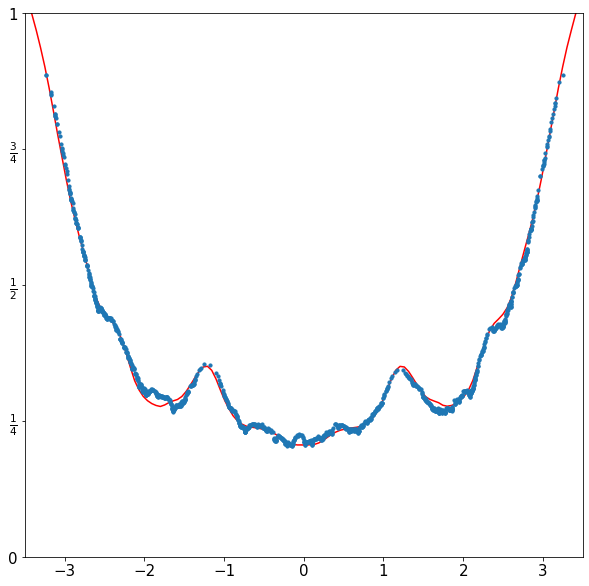

In [326]:
fig, ax = plt.subplots(figsize = (10,10))
plt.rcParams.update({'font.size': 15})
ax.scatter(bandcentres,bandwidths,10,zorder = 2)
ax.plot(energies,Lyapunovexponent,'r-',linewidth = 1.5,zorder = 1)
ax.set(xlim=(-3.5, 3.5),ylim=(0, 1))
plt.yticks([0,1/4,1/2,3/4,1], [r'$0$',r'$\frac{1}{4}$',r'$\frac{1}{2}$',r'$\frac{3}{4}$',r'$1$'])
plt.savefig('IID_bandwidths.eps')